# Trabajo Práctico Nº3 - Big Data

### Mateo Servent, Joaquín Musich y Andres Cuellas

### Parte I: Análisis de la base de hogares y cálculo de pobreza

In [364]:
import pandas as pd

# Leer la base de datos
df = pd.read_excel('/Users/macbook/Desktop/UdeSa/Materias/Big data/Big-Data/TP3/usu_hogar_T123.xlsx')

# Estadísticos descriptivos (más la exploración del libro de codigos)
 
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ANO4,16815.0,2023.000000,0.000000,2023.0,2023.0,2023.0,2023.0,2023.0
TRIMESTRE,16815.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
NRO_HOGAR,16815.0,1.064347,1.177592,1.0,1.0,1.0,1.0,52.0
REALIZADA,16815.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
REGION,16815.0,35.439191,15.237237,1.0,40.0,42.0,43.0,44.0
...,...,...,...,...,...,...,...,...
VII1_2,16815.0,0.590009,2.756843,0.0,0.0,0.0,0.0,97.0
VII2_1,16815.0,70.012608,43.469641,1.0,3.0,98.0,98.0,98.0
VII2_2,16815.0,0.403449,3.397350,0.0,0.0,0.0,0.0,98.0
VII2_3,16815.0,0.103836,1.289136,0.0,0.0,0.0,0.0,98.0


### A partir de un análisis preliminar, consideramos que posibles determinantes claves en la predicción de la pobreza dentro del conjunto de datos de hogares serían los atributos vinculados a la infraestructura habitacional (calidad estructural, conectividad a servicios básicos, instalaciones sanitarias), el esquema de propiedad o alquiler del inmueble y la distribución demográfica por edad en el núcleo familiar. Estos indicadores, podrían llegar a ser considerados esenciales para una estimación más afinada.

In [365]:
# 2)
# Filtrar observaciones
df_filtrado = df[df['AGLOMERADO'].isin([32, 33])]

In [366]:
# 3)

dfI = pd.read_excel('/Users/macbook/Desktop/UdeSa/Materias/Big data/Big-Data/TP2/EPH_usu_1er_Trim_2023/usu_individual_T123.xlsx')

dfI = dfI[dfI['AGLOMERADO'].isin([32, 33])]

# Definimos las intersección entre las dos bases como una lista
columnas_duplicadas = set(dfI.columns).intersection(set(df_filtrado.columns))
# Removemos CODUSU y NRO_HOGAR de la lista ya que queremos usarlas para la intersección 
#(y las columnas sobre las que se une no generan duplicados)
columnas_duplicadas.remove("CODUSU")
columnas_duplicadas.remove("NRO_HOGAR")

# Hacemos el merge habiendo dropeado las columnas repetidas
df2 = pd.merge(
    dfI.drop(columnas_duplicadas, axis=1), 
    df_filtrado,
    on= ['NRO_HOGAR', 'CODUSU'])

In [473]:
# 4 y 5 ) 
def eliminar_categoria_9(df, column_list):
    """
    Elimina la categoría con valor 9 de una serie de variables en un DataFrame.
    
    Parámetros:
    - df: DataFrame donde se encuentran las columnas.
    - column_list: Lista de columnas en las que se quiere eliminar la categoría con valor 9.
    
    Retorna:
    - DataFrame con las categorías con valor 9 eliminadas en las columnas especificadas.
    """
    for column in column_list:
        df = df[df[column] != 9]
    return df


df3 = eliminar_categoria_9(df2, ['NIVEL_ED', 'CH08', 'CH07', 'CAT_OCUP', 'CH15', 'CH16']) 
# Hay más NAs en otras variables
df4 = df3[(df3['CH06'] > 0)] # Edad menor a cero

In [474]:
def columnas_duplicadas(df):
    """
    Esta función verifica si hay columnas con valores idénticos en un DataFrame.
    
    Argumentos:
    - df: DataFrame de pandas
    
    Retorna:
    - Una lista de tuplas con los nombres de las columnas repetidas.
    """
    
    columnas_repetidas = []
    
    for i in range(df.shape[1]):
        for j in range(i+1, df.shape[1]):
            if df.iloc[:, i].equals(df.iloc[:, j]):
                columnas_repetidas.append((df.columns[i], df.columns[j]))
    
    return columnas_repetidas


def eliminar_columnas_duplicadas(df):
    # Obtener las columnas duplicadas
    cols_duplicadas = columnas_duplicadas(df)
    
    # Crear una lista de columnas para eliminar
    columnas_para_eliminar = [col[1] for col in cols_duplicadas]
    
    # Eliminar las columnas
    df = df.drop(columns=columnas_para_eliminar)
    
    return df

In [475]:
eliminar_columnas_duplicadas(df4) # verificamos si hubiera columnas duplicadas y las eliminamos

def drop_high_na(df, threshold=0.7):
    """
    Elimina las columnas y las filas del DataFrame que tienen un porcentaje de valores faltantes 
    superior al umbral especificado.

    Parámetros:
    - df: DataFrame de entrada.
    - threshold: umbral de porcentaje de valores faltantes para eliminar una columna o fila (valor predeterminado = 0.7).

    Retorna:
    - DataFrame después de eliminar las columnas y filas con un alto porcentaje de valores faltantes.
    """
    # Calcula el porcentaje de valores faltantes para cada columna
    missing_percentage_col = df.isnull().mean()
    
    # Filtra las columnas que tienen un porcentaje de valores faltantes superior al umbral
    columns_to_drop = missing_percentage_col[missing_percentage_col > threshold].index
    
    # Elimina las columnas seleccionadas del DataFrame
    df_cleaned = df.drop(columns=columns_to_drop)
    
    # Calcula el porcentaje de valores faltantes para cada fila
    missing_percentage_row = df_cleaned.isnull().mean(axis=1)
    
    # Filtra las filas que tienen un porcentaje de valores faltantes superior al umbral
    rows_to_drop = missing_percentage_row[missing_percentage_row > threshold].index
    
    # Elimina las filas seleccionadas del DataFrame
    df_cleaned = df_cleaned.drop(index=rows_to_drop)
    
    return df_cleaned

drop_high_na(df4)

,CODUSU,NRO_HOGAR,COMPONENTE,H15,CH03,CH04,CH05,CH06,CH07,CH08,...,RDECCFR,GDECCFR,ADECCFR,PONDIH,VII1_1,VII1_2,VII2_1,VII2_2,VII2_3,VII2_4
0,TQRMNORUYHLMSMCDEIJAH00719364,1,1,1,1,2,1957-10-17 00:00:00,65,1,1.0,...,5,5.0,6,2540,1,0,2,0,0,0
1,TQRMNORUYHLMSMCDEIJAH00719364,1,2,1,2,1,1952-04-07 00:00:00,70,1,1.0,...,5,5.0,6,2540,1,0,2,0,0,0
2,TQRMNOSRQHJNSOCDEIJAH00802640,1,1,1,1,1,1986-09-26 00:00:00,36,1,4.0,...,1,1.0,1,14082,2,1,98,0,0,0
3,TQRMNOSRQHJNSOCDEIJAH00802640,1,2,1,2,2,1994-05-02 00:00:00,28,1,4.0,...,1,1.0,1,14082,2,1,98,0,0,0
4,TQRMNOSRQHJNSOCDEIJAH00802640,1,3,0,3,2,2014-03-20 00:00:00,9,5,4.0,...,1,1.0,1,14082,2,1,98,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7614,TQRMNOPVVHKLRQCDEIJAH00780546,1,3,0,3,1,2013-08-05 00:00:00,9,5,2.0,...,9,9.0,9,2295,1,2,98,0,0,0
7615,TQRMNOQPTHKKRRCDEIJAH00780327,1,1,1,1,2,1945-06-05 00:00:00,77,3,1.0,...,10,10.0,10,1516,1,0,96,0,0,0
7616,TQRMNOPTXHKORSCDEIJAH00780269,1,1,1,1,2,1977-07-31 00:00:00,45,5,1.0,...,12,12.0,12,0,1,2,3,0,0,0
7617,TQRMNOPTXHKORSCDEIJAH00780269,1,2,1,3,1,2005-06-17 00:00:00,17,5,1.0,...,12,12.0,12,0,1,2,3,0,0,0


In [476]:
# Crear una copia del DataFrame para evitar SettingWithCopyWarning
df4_copy = df4.copy()

# Ajustamos la variable 'Nivel_ed'. 
df4_copy['NIVEL_ED'].replace(7, 0, inplace=True)

# Convertimos las variables categóricas a formato de cadena
category_list = [ 'CH08', 'CH09', 'T_VI', 'V10_M', 'IV1', 'IV3', 'IV4', 'IV6', 'IV7', 'IV9', 'IV10', 'II7', 'II8', 'II9', 'IV11']
df_categories = df4_copy[category_list].astype(str)

# Creamos variables dummy para las variables categóricas
dummy_data = pd.get_dummies(df_categories, prefix=category_list)

# Fusionamos las variables dummy con el DataFrame original, excluyendo las originales
df4_copy = pd.concat([df4_copy, dummy_data], axis=1)
df4_copy.drop(category_list, axis=1, inplace=True)

In [477]:
df4 = df4_copy.copy()

# Eliminamos las columnas ANO4 y TRIMESTRE de df4
df4.drop(['ANO4', 'TRIMESTRE'], axis=1, inplace=True)

def resumen_dataframe(df):
    print(f"Total de filas: {df.shape[0]}")
    print(f"Total de columnas: {df.shape[1]}")

resumen_dataframe(df4)

Total de filas: 7536
Total de columnas: 572


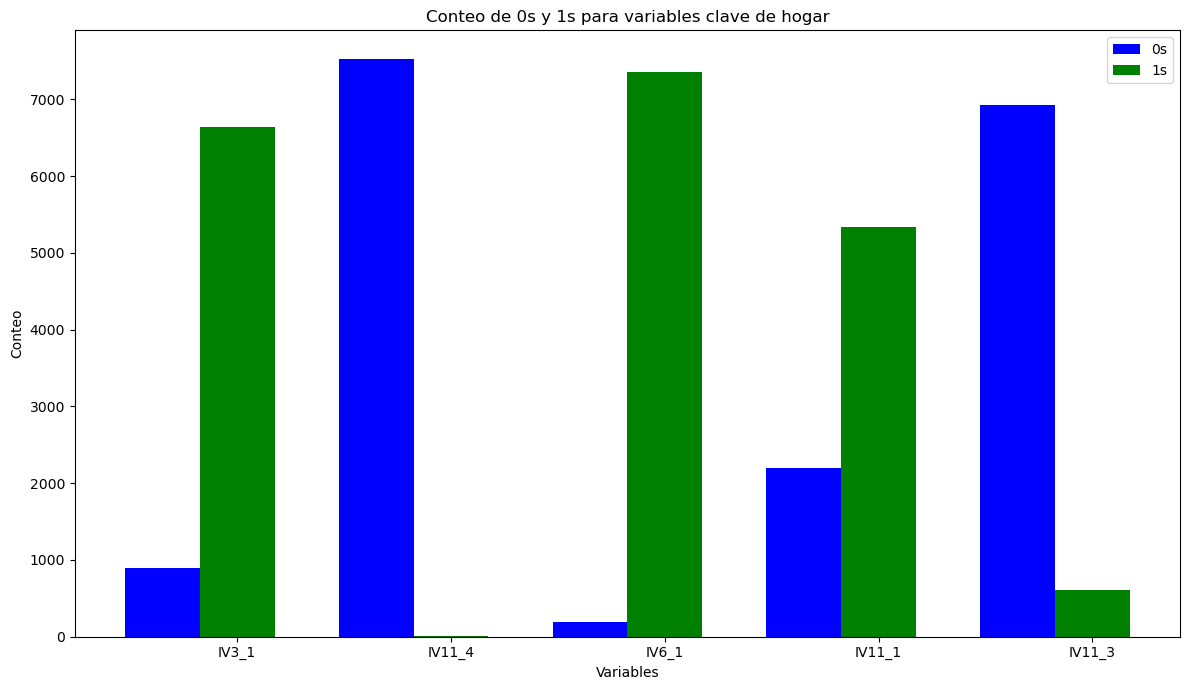

In [478]:
# 6) Estadísticas descriptivas
# IV6: Suministro de agua. 1. por cañería dentro de la vivienda
# IV3: Tipos de piso interior. 1. mosaico / baldosa / madera /cerámica / alfombra
# IV11: Desague del baño. 1: a red pública (cloaca),  3. solo pozo ciego y 4. hoyo/excavación en la tierra


fig, ax = plt.subplots(figsize=(12, 7))

variables = ['IV3_1', 'IV11_4', 'IV6_1', 'IV11_1', 'IV11_3']

# Espacio entre las barras
bar_width = 0.35
index = range(len(variables))

# Loop por cada variable
bar1_values = []
bar2_values = []
for var in variables:
    count_0 = (df4[var] == 0).sum()
    count_1 = (df4[var] == 1).sum()
    bar1_values.append(count_0)
    bar2_values.append(count_1)

bar1 = ax.bar(index, bar1_values, bar_width, label='0s', color='b')
bar2 = ax.bar([i + bar_width for i in index], bar2_values, bar_width, label='1s', color='g')

# Etiquetas y título
ax.set_xlabel('Variables')
ax.set_ylabel('Conteo')
ax.set_title('Conteo de 0s y 1s para variables clave de hogar')
ax.set_xticks([i + bar_width for i in index])
ax.set_xticklabels(variables)
ax.legend()

plt.tight_layout()
plt.show()

In [479]:
# 7) 
adultos_data = pd.read_excel("/Users/macbook/Desktop/UdeSa/Materias/Big data/Big-Data/TP2/tabla_adulto_equiv.xlsx", skiprows=3)
adultos_data = adultos_data.dropna(how='all')
adultos_data = adultos_data.iloc[:23, :]

def categorize_age(age):
    if age == 0:
        return "Menor de 1 año"
    elif age == 1:
        return "1 año"
    elif age == 2:
        return "2 años"
    elif age == 3:
        return "3 años"
    elif age == 4:
        return "4 años"
    elif age == 5:
        return "5 años"
    elif age == 6:
        return "6 años"
    elif age == 7:
        return "7 años"
    elif age == 8:
        return "8 años"
    elif age == 9:
        return "9 años"
    elif age == 10:
        return "10 años"
    elif age == 11:
        return "11 años"
    elif age == 12:
        return "12 años"
    elif age == 13:
        return "13 años"
    elif age == 14:
        return "14 años"
    elif age == 15:
        return "15 años"
    elif age == 16:
        return "16 años"
    elif age == 17:
        return "17 años"
    elif 18 <= age <= 29:
        return "18 a 29 años"
    elif 30 <= age <= 45:
        return "30 a 45 años"
    elif 46 <= age <= 60:
        return "46 a 60 años"
    elif 61 <= age <= 75:
        return "61 a 75 años"
    else:
        return "más de 75 años"

# Creando la columna "Rango de Edad"
df4.loc[:, 'Edad'] = df4['CH06'].apply(categorize_age)

# Creando dos dataframes: uno para Mujeres y otro para Varones
df_mujeres = adultos_data[['Edad', 'Mujeres']].copy()
df_mujeres['CH04'] = 2
df_mujeres.rename(columns={'Mujeres': 'adulto_equiv'}, inplace=True)

df_varones = adultos_data[['Edad', 'Varones']].copy()
df_varones['CH04'] = 1
df_varones.rename(columns={'Varones': 'adulto_equiv'}, inplace=True)

# Concatenando ambos dataframes
adultos_equiv_data = pd.concat([df_mujeres, df_varones], axis=0)

# Reordenando las columnas y ordenando el dataframe por Edad
adultos_equiv_data = adultos_equiv_data[['Edad', 'CH04', 'adulto_equiv']]
adultos_equiv_data = adultos_equiv_data.sort_values(by=['Edad', 'CH04']).reset_index(drop=True)

In [480]:
# Uniendo df4 con adultos_equiv_data usando las columnas "Edad" y "CH04"
df5 = pd.merge(df4, adultos_equiv_data[['Edad', 'CH04', 'adulto_equiv']],
               on=['Edad', 'CH04'], how='left')

# Mostrando las primeras filas de la base resultante
df5[['CH04', 'CH06', 'Edad', 'adulto_equiv']].head()

# Agrupar por NRO_HOGAR y CODUSU y calcular la suma de adultos_equiv para cada combinación
sum_adulto_equiv = df5.groupby(['NRO_HOGAR', 'CODUSU'])['adulto_equiv'].sum().reset_index(name='ad_equiv_hogar')

# Fusionar con df5 para asignar los valores calculados a la columna ad_equiv_hogar
df6 = pd.merge(df5, sum_adulto_equiv, on=['NRO_HOGAR', 'CODUSU'], how='left')
df6 = df6.copy()

# Mostrar las primeras 10 filas del DataFrame para verificar
df6[['NRO_HOGAR', 'CODUSU', 'adulto_equiv', 'ad_equiv_hogar']].head(10)

,NRO_HOGAR,CODUSU,adulto_equiv,ad_equiv_hogar
0,1,TQRMNORUYHLMSMCDEIJAH00719364,0.67,1.50
1,1,TQRMNORUYHLMSMCDEIJAH00719364,0.83,1.50
2,1,TQRMNOSRQHJNSOCDEIJAH00802640,1.00,2.45
3,1,TQRMNOSRQHJNSOCDEIJAH00802640,0.76,2.45
4,1,TQRMNOSRQHJNSOCDEIJAH00802640,0.69,2.45
5,1,TQRMNOSWQHJLQRCDEIJAH00796254,1.00,2.00
6,1,TQRMNOSWQHJLQRCDEIJAH00796254,1.00,2.00
7,1,TQRMNOPYVHLMRLCDEIJAH00719346,1.00,2.78
8,1,TQRMNOPYVHLMRLCDEIJAH00719346,0.76,2.78
9,1,TQRMNOPYVHLMRLCDEIJAH00719346,1.02,2.78


In [481]:
# 8) División entre quienes reportaron ingresos y entre quienes no lo hicieron
# Ingreso neesario según canasta básica

norespondieron = df6[(df6['DECIFR'] == 12) | (df6['DECIFR'] == 13) & (df6['ITF'] == 0)].copy()
respondieron = df6[(df6['DECIFR'] != 12) & (df6['DECIFR'] != 13) & (df6['ITF'] != 0)].copy()

canasta_basica_total = 57371.05

respondieron['ingreso_necesario'] = respondieron['ad_equiv_hogar'] * canasta_basica_total
norespondieron['ingreso_necesario'] = norespondieron['ad_equiv_hogar'] * canasta_basica_total

#9) 
# Variable de conteo casos divididos por la línea de pobreza

respondieron['pobre'] = (respondieron['ITF'] < respondieron['ingreso_necesario']).astype(int)

In [482]:
# 10) 
# Filtrar solo los hogares que son pobres
hogares_pobres = respondieron[respondieron['pobre'] == 1]

In [485]:
# Sumar el ponderador PONDIH para los hogares únicos
total_hogares_ponderados = respondieron.drop_duplicates(subset=['CODUSU', 'NRO_HOGAR'])['PONDIH'].sum()

# Sumar el ponderador PONDIH para los hogares únicos que son pobres
hogares_pobres_ponderados = hogares_pobres.drop_duplicates(subset=['CODUSU', 'NRO_HOGAR'])['PONDIH'].sum()

# Calcular el porcentaje de hogares pobres ponderados en relación al total ponderado
porcentaje_hogares_pobres_ponderados = (hogares_pobres_ponderados / total_hogares_ponderados) * 100

print(f'Número ponderado de hogares identificados como pobres: {hogares_pobres_ponderados}')
print(f'Porcentaje ponderado de hogares identificados como pobres: {porcentaje_hogares_pobres_ponderados:.2f}%')

Número ponderado de hogares identificados como pobres: 1499962
Porcentaje ponderado de hogares identificados como pobres: 28.24%


### La diferencia con los valores que reporta INDEC (30,3%), tiene que ver con el tratamiento que dieron a valores faltantes y al no reporte de ingresos. Recordamos que en nuestro caso eliminamos casos donde el 70% de los valores de la fila o columna eran NAs y, además, solo estamos considerando quienes reportaron ingresos. 

# Parte II: Construcción de funciones

In [486]:
# 1)
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

def evalua_modelo(x_train, y_train, x_test, y_test, tipos=['logistico', 'LDA', 'kNN'], lambda_=1.0, k_neighbors=5):
    # Estandarizar datos
    sc = StandardScaler()
    x_train = sc.fit_transform(x_train)
    x_test = sc.transform(x_test)

    # DataFrame para almacenar resultados
    resultados = pd.DataFrame({
        'Metrica': ['AUC', 'Accuracy', 'ECM', 'True P', 'False P', 'True N', 'False N'],
        'Lambda': [np.nan] * 7,  # Columna vacía para lambda
        'k_neighbors': [np.nan] * 7  # Columna vacía para k_neighbors
    })

    for tipo in tipos:
        # Ajustar el modelo y establecer el hiperparámetro
        if tipo == 'logistico':
            modelo = LogisticRegression(C=1/lambda_, max_iter=10000).fit(x_train, y_train)
            resultados['Lambda'] = lambda_
        elif tipo == 'LDA':
            modelo = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto').fit(x_train, y_train)
        elif tipo == 'kNN':
            modelo = KNeighborsClassifier(n_neighbors=k_neighbors).fit(x_train, y_train)
            resultados['k_neighbors'] = k_neighbors
        else:
            raise ValueError(f"Tipo de modelo {tipo} no reconocido.")
        
        # Predicciones
        y_pred = modelo.predict(x_test)
        y_pred_proba = modelo.predict_proba(x_test)[:, 1]
        
        # Métricas
        conf_matrix = confusion_matrix(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_proba)
        acc = accuracy_score(y_test, y_pred)
        ecm = mean_squared_error(y_test, y_pred)
        
        # Almacenar resultados en el DataFrame
        resultados[f'Valor_{tipo}'] = [auc, acc, ecm, 
                                      conf_matrix[1, 1], conf_matrix[0, 1],
                                      conf_matrix[0, 0], conf_matrix[1, 0]]

    # Redondear los valores a dos decimales
    for col in resultados.columns[1:]:
        resultados[col] = resultados[col].apply(lambda x: round(x, 3) if isinstance(x, (int, float)) else x)

    return resultados

In [487]:
from sklearn.impute import SimpleImputer

# Separar las características (X) y la variable dependiente (y)
X = respondieron.drop('pobre', axis=1)
X = X.select_dtypes(include=["number"])  # mantenemos las variables numéricas

# Eliminar las columnas que solo contienen NaN
X = X.dropna(axis=1, how='all')

# Imputar datos faltantes con la media, es una medida conroversial. Permite continuar con las predicciones sin 
# perder mucha información, pero se atribuye valores incorrectos a casos que no reportan información.
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)

# Asegurarse de que y tenga las mismas filas que X_imputed
y_cleaned = respondieron.loc[X_imputed.index, 'pobre']

# Dividir los datos en conjuntos de entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(X_imputed, y_cleaned, test_size=0.3, random_state=2023)


print("Conjunto de entrenamiento:", "X_train =", len(x_train), "Y_train =", len(y_train))
print("Conjunto de prueba:", "X_test =", len(x_test), "Y_test =", len(y_test))

evalua_modelo(x_train, y_train, x_test, y_test) # evalua los 3 pero se podría seleccionar solo 1 o 2

Conjunto de entrenamiento: X_train = 2919 Y_train = 2919
Conjunto de prueba: X_test = 1252 Y_test = 1252


,Metrica,Lambda,k_neighbors,Valor_logistico,Valor_LDA,Valor_kNN
0,AUC,1.0,5,0.994,0.982,0.904
1,Accuracy,1.0,5,0.961,0.932,0.836
2,ECM,1.0,5,0.039,0.068,0.164
3,True P,1.0,5,418.000,416.000,321.000
4,False P,1.0,5,21.000,55.000,80.000
5,True N,1.0,5,785.000,751.000,726.000
6,False N,1.0,5,28.000,30.000,125.000


In [488]:
# 2) 
from sklearn.model_selection import StratifiedKFold

def cross_validation(X, y, k=10, modelos=['logistico', 'LDA', 'kNN']):
    # El valor predeterminado para k particiones es 10
    # modelos es una lista de los tipos de modelos a evaluar, por defecto se evalúan los tres.
    
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=2023) 
    # subconjuntos estratificados mejoran las particiones y dan mayor estabilidad a las métricas
    resultados_totales = []

    for train_index, test_index in skf.split(X, y):  # pasamos 'y' también a skf.split
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Evaluamos todos los modelos especificados en la lista modelos
        resultados = evalua_modelo(X_train, y_train, X_test, y_test, modelos)
        resultados_totales.append(resultados)

    # Consolidar los resultados en un único DataFrame
    resultados_df = pd.concat(resultados_totales, axis=0).reset_index(drop=True)
    
    # Añadir una columna para identificar el fold
    resultados_df['Fold'] = [i+1 for i in range(k) for _ in range(len(resultados))]
    
    # Reordenar las columnas para que 'Fold' aparezca al principio
    cols = resultados_df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    resultados_df = resultados_df[cols]

    return resultados_df

cross_validation(X_imputed, y_cleaned)

,Fold,Metrica,Lambda,k_neighbors,Valor_logistico,Valor_LDA,Valor_kNN
0,1,AUC,1.0,5,0.997,0.989,0.925
1,1,Accuracy,1.0,5,0.978,0.959,0.859
2,1,ECM,1.0,5,0.022,0.041,0.141
3,1,True P,1.0,5,152.000,152.000,122.000
4,1,False P,1.0,5,6.000,14.000,26.000
...,...,...,...,...,...,...,...
65,10,ECM,1.0,5,0.024,0.060,0.134
66,10,True P,1.0,5,150.000,147.000,119.000
67,10,False P,1.0,5,5.000,17.000,20.000
68,10,True N,1.0,5,257.000,245.000,242.000


In [502]:
# 3) Integramos la dos funciones pasadas 

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, mean_squared_error
import numpy as np

def evalua_config(X, y, lambda_values=[1.0], k_neighbors_values=[5], k=10, modelos=['logistico', 'LDA', 'kNN']):
    # Lista para almacenar los resúmenes de todas las combinaciones
    resumenes_totales = []
    
    # Iterar sobre cada valor de lambda y k_neighbors
    for lambda_ in lambda_values:
        for k_neighbors in k_neighbors_values:
            
            # Realizar la validación cruzada
            resultados_df = cross_validation(X, y, k=k, modelos=modelos)
            
            # Evaluar el ECM mínimo y extraer la información correspondiente
            metodos = ['Valor_logistico', 'Valor_LDA', 'Valor_kNN']
            
            for metodo in metodos:
                min_ecm = resultados_df[resultados_df['Metrica'] == 'ECM'][metodo].min()
                row = resultados_df[(resultados_df['Metrica'] == 'ECM') & (resultados_df[metodo] == min_ecm)]
                
                resumenes_totales.append({
                    'Metodo': metodo,
                    'ECM_minimo': min_ecm,
                    'Lambda': lambda_ if 'logistico' in metodo else np.nan,
                    'Fold': row['Fold'].values[0],
                    'k_neighbors': k_neighbors if 'kNN' in metodo else np.nan
                })

    resumen_total = pd.DataFrame(resumenes_totales)
    
    # Encontrar los mejores parámetros para cada método
    mejor_lambda_logistico = resumen_total[resumen_total['Metodo'] == 'Valor_logistico']['Lambda'].iloc[0]
    mejor_fold_LDA = resumen_total[resumen_total['Metodo'] == 'Valor_LDA']['Fold'].iloc[0]
    mejor_k_neighbors_kNN = resumen_total[resumen_total['Metodo'] == 'Valor_kNN']['k_neighbors'].iloc[0]
    
    return {
        'Optimo lambda para regresión logística': mejor_lambda_logistico,
        'Optima cantidad de particiones (fold) para LDA': mejor_fold_LDA,
        'Optima cantidad de vecinos para kNN': mejor_k_neighbors_kNN
    }

# Ejemplo de uso:
evalua_config(X_imputed, y_cleaned, lambda_values=[1, 10], k_neighbors_values=[3, 5], k=5)

{'Optimo lambda para regresión logística': 1.0,
 'Optima cantidad de particiones (fold) para LDA': 1,
 'Optima cantidad de vecinos para kNN': 3.0}

In [508]:
# 4)

def evalua_multiples_metodos(X, y, lambda_values=[1.0], k_neighbors_values=[5], k=10, modelos=['logistico', 'LDA', 'kNN']):
    # Lista para almacenar los resúmenes de todas las combinaciones
    resumenes_totales = []
    
    # Iterar sobre cada valor de lambda y k_neighbors
    for lambda_ in lambda_values:
        for k_neighbors in k_neighbors_values:
            
            # Realizar la validación cruzada
            resultados_df = cross_validation(X, y, k=k, modelos=modelos)
            
            # Evaluar el ECM mínimo y extraer la información correspondiente
            metodos = ['Valor_logistico', 'Valor_LDA', 'Valor_kNN']
            
            for metodo in metodos:
                min_ecm = resultados_df[resultados_df['Metrica'] == 'ECM'][metodo].min()
                rows_with_min_ecm = resultados_df[(resultados_df['Metrica'] == 'ECM') & (resultados_df[metodo] == min_ecm)]
                
                # Seleccionar aleatoriamente una fila si hay múltiples filas con el mismo ECM mínimo para el método
                selected_row = rows_with_min_ecm.sample(1).iloc[0]
                
                resumenes_totales.append({
                    'Metodo': metodo,
                    'ECM_minimo': min_ecm,
                    'Lambda': lambda_ if 'logistico' in metodo else np.nan,
                    'Fold': selected_row['Fold'],
                    'k_neighbors': k_neighbors if 'kNN' in metodo else np.nan
                })

    resumen_total = pd.DataFrame(resumenes_totales)
    resumen_total = resumen_total.drop_duplicates(subset=['ECM_minimo', 'Metodo']).reset_index(drop=True)
    return resumen_total.drop_duplicates().reset_index(drop=True)

evalua_multiples_metodos(X_imputed, y_cleaned, lambda_values=[1, 10], k_neighbors_values=[3, 5], k=15)
# Probamos con otra cantidad de particiones, se reduce el ECM pero se corre más riesgo de encontrar más overfiting 

,Metodo,ECM_minimo,Lambda,Fold,k_neighbors
0,Valor_logistico,0.007,1.0,14,NaN
1,Valor_LDA,0.032,NaN,14,NaN
2,Valor_kNN,0.108,NaN,2,3.0


# Parte III

In [527]:
# 1)

# Lista de columnas a eliminar
columnas_eliminar = [
    "PP08D1", "PP08D4", "PP08F1", "PP08F2", "PP08J1", "PP08J2", "PP08J3",
    "P21", "DECOCUR", "IDECOCUR", "RDECOCUR", "GDECOCUR", "PDECOCUR", "ADECOCUR", "PONDIIO",
    "TOT_P12",
    "P47T", "DECINDR", "IDECINDR", "RDECINDR", "GDECINDR", "PDECINDR", "ADECINDR", "PONDII",
    "V2_M", "V3_M", "V4_M", "V5_M", "V8_M", "V9_M", "V11_M", "V12_M", "V18_M", "V19_AM", "V21_M",
    "ITF", "DECIFR", "IDECIFR", "RDECIFR", "GDECIFR", "PDECIFR", "ADECIFR",
    "IPCF", "DECCFR", "IDECCFR", "RDECCFR", "GDECCFR", "PDECCFR", "ADECCFR", "PONDIH",
    "adulto_equiv", "ad_equiv_hogar", "ingreso_necesario"]

# Limpiando los dataframes
clean_respondieron = respondieron.drop(columns=columnas_eliminar)
clean_no_respondieron = norespondieron.drop(columns=columnas_eliminar)

# Seleccionar todas las características observadas, excluyendo la columna "pobre"
X = clean_respondieron.drop(columns=["pobre"])
X = X.select_dtypes(include=["number"])  # mantenemos las variables numéricas
# Eliminar las columnas que solo contienen NaN
X = X.dropna(axis=1, how='all')

# Añadir una columna constante al conjunto de características observables
X["constante"] = 1

# Imputar datos faltantes con la media, es una medida conroversial. Permite continuar con las predicciones sin 
# perder mucha información, pero se atribuye valores incorrectos a casos que no reportan información.
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)

# Establecer la variable dependiente con las mismas filas que X_imputed
y_cleaned = respondieron.loc[X_imputed.index, 'pobre']

# Imprimiendo las columnas restantes de cada dataframe
print("Columnas en X:")
print(X_imputed.columns)

print("\nColumnas en Y:")
print(y_cleaned.name) 

Columnas en X:
Index(['NRO_HOGAR', 'COMPONENTE', 'H15', 'CH03', 'CH04', 'CH06', 'CH07',
       'CH10', 'CH11', 'CH12',
       ...
       'II9_1', 'II9_2', 'II9_3', 'II9_4', 'IV11_0', 'IV11_1', 'IV11_2',
       'IV11_3', 'IV11_4', 'constante'],
      dtype='object', length=513)

Columnas en Y:
pobre


In [538]:
# 2) 

evaluacion = evalua_multiples_metodos(X_imputed, y_cleaned, lambda_values=[1, 10])

print(evaluacion.iloc[0, 0:4])

Metodo        Valor_logistico
ECM_minimo              0.144
Lambda                    1.0
Fold                        1
Name: 0, dtype: object


### 3) La elección del parámetro de regularización, λ, es crucial para prevenir el sobreajuste en modelos como la regresión Lasso o Ridge. Utilizamos validación cruzada, como el método k-fold, para determinar el λ óptimo en el conjunto de entrenamiento. Es necesario no usar el conjunto de prueba en este proceso para evitar el "data leakage", que comprometería la evaluación imparcial del modelo. Usar el conjunto de prueba para ajustar parámetros puede sesgar nuestra percepción del rendimiento real del modelo, llevando a una subestimación del error en datos no vistos. Por lo tanto, el conjunto de prueba debe reservarse exclusivamente para una evaluación final del modelo.

### 4) La validación cruzada es un método esencial para estimar el rendimiento de un modelo dividiendo el conjunto de entrenamiento en k subconjuntos distintos, conocidos como "folds", particiones o subconjuntos. Cada fold se emplea una vez como conjunto de prueba, mientras que los k-1 folds restantes componen el conjunto de entrenamiento. La elección del valor de k es crucial. Si k es demasiado pequeño, aunque el proceso será computacionalmente menos costoso, el estimado del error tendrá mayor varianza y puede no ser representativo, especialmente en datasets pequeños. Por otro lado, un k grande conduce a una estimación de error más precisa con menos sesgo, pero a costa de un mayor tiempo de cálculo. Además, a medida que k crece, los conjuntos de entrenamiento se asemejan más entre sí, lo que puede resultar en una visión demasiado optimista del rendimiento. En el caso donde k = n (siendo n el número de muestras), denominado "validación cruzada de eliminación" o "leave-one-out cross-validation (LOOCV)", se estima el modelo n veces. Esta aproximación, aunque precisa, es computacionalmente intensiva, especialmente para conjuntos de datos de gran tamaño o modelos intrincados.